# Ejercicio 2 – Predicción de series temporales con ARIMA

## ¿Qué es ARIMA?

**ARIMA** (AutoRegressive Integrated Moving Average) es uno de los modelos estadísticos más utilizados para predecir series temporales. Funciona especialmente bien cuando se tiene una única variable a lo largo del tiempo y se busca capturar patrones como tendencias o ciclos.

Su potencia radica en tres componentes principales:

- **AR (Auto-Regresión)**: La serie se predice a partir de sus propios valores pasados.
- **I (Integración)**: Diferenciación para hacer la serie estacionaria.
- **MA (Media Móvil)**: Utiliza errores pasados para mejorar la predicción.

El modelo se representa como:  
📌 `ARIMA(p, d, q)`  
donde:
- `p`: representa el número de observaciones rezagadas (lags). Nos indica cuántos pasos atrás en el tiempo debemos mirar para predecir el valor actual. Se determina observando la autocorrelación de la serie.
- `d`: es el orden de diferenciación, es decir, cuántas veces hay que restar el valor actual con respecto al anterior para hacer que la serie sea estacionaria (sin tendencia ni variación en la varianza).
- `q`:  Representa cuántos errores de predicción pasados se incorporan en el modelo. A diferencia de una media móvil tradicional que suaviza datos, aquí se usa para modelar la relación entre los errores pasados y los valores actuales.

---

## Conceptos clave

- **Estacionariedad**: Una serie estacionaria mantiene sus propiedades estadísticas constantes a lo largo del tiempo. ARIMA requiere que la serie sea estacionaria para funcionar correctamente.
- **Autocorrelación**: Se refiere a cómo se relaciona una observación con valores pasados. Se mide con ACF y PACF.
- **Diferenciación**: Técnica para eliminar tendencia y hacer la serie estacionaria restando el valor anterior:  
  \[
  Y'_t = Y_t - Y_{t-1}
  \]

---

## Flujo de trabajo

```mermaid
flowchart TD
    A[Serie temporal entrenamiento] --> B[Test de estacionariedad ADF]
    B --> C[Aplicar diferenciación si es necesario]
    C --> D[Análisis ACF y PACF]
    D --> E[Selección de parámetros p, d, q]
    E --> F[Entrenamiento del modelo ARIMA]
    F --> G[Predicción y evaluación con set de validación]
    G --> H[Visualización y análisis de errores]
```

---

## Ejercicio práctico

### Paso 1: Cargar datos preparados (train / validation)

In [2]:
import pandas as pd

# Cargar datasets desde archivo CSVs
train = pd.read_csv("data/m5_consumo_energia_train.csv", index_col=0)
val = pd.read_csv("data/m5_consumo_energia_test.csv", index_col=0)

# Establecer columna temporal como índice
train.set_index(pd.to_datetime(train.index), inplace=True)
# Cargar dataset desde archivo CSV

# Establecer columna temporal como índice
val.set_index(pd.to_datetime(val.index), inplace=True)

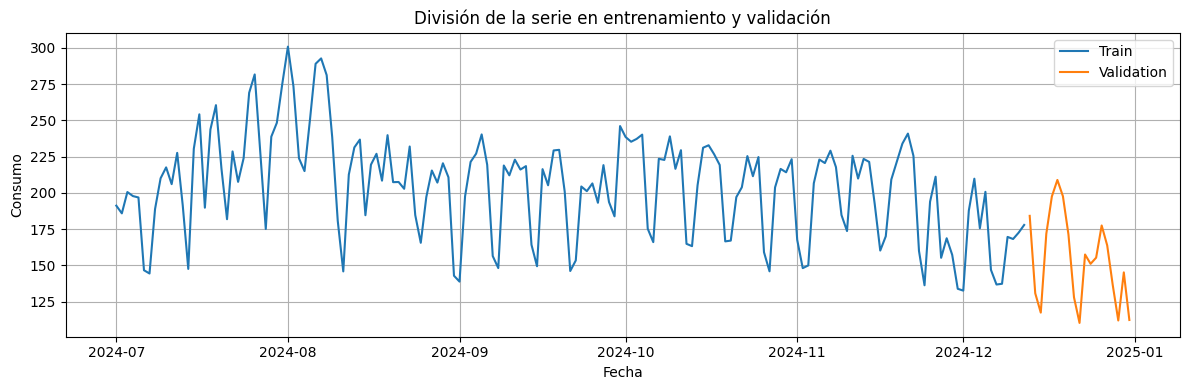

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train.index, train["Energia Consumida"], label="Train")
plt.plot(val.index, val["Energia Consumida"], label="Validation")
plt.title("División de la serie en entrenamiento y validación")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 2: Verificar estacionariedad con prueba ADF

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train["Energia Consumida"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("La serie NO es estacionaria. Se recomienda aplicar diferenciación.")
else:
    print("La serie es estacionaria.")

ADF Statistic: -0.8852591514773757
p-value: 0.792788023312716
La serie NO es estacionaria. Se recomienda aplicar diferenciación.


---

### Paso 3: Aplicar diferenciación si es necesario

/var/folders/kh/vywr4v293s1fmshzbj358gw40000gn/T/ipykernel_5433/3319043480.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


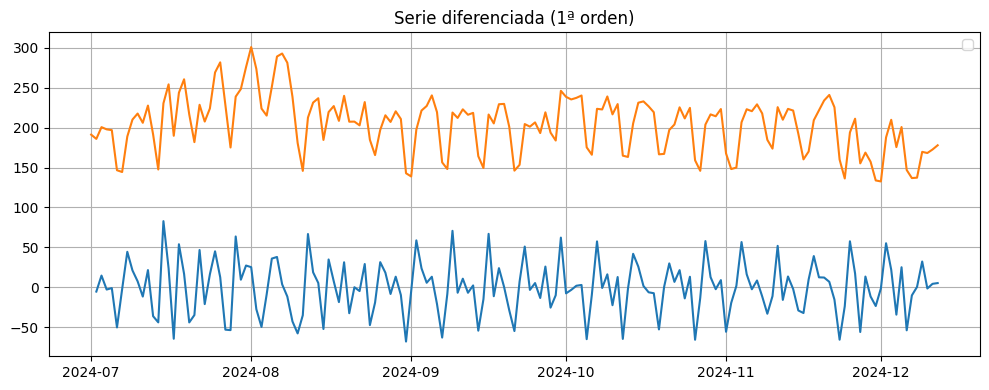

In [5]:
train_diff = train["Energia Consumida"].diff().dropna()

# Visualizar la serie diferenciada
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_diff)
plt.plot(train["Energia Consumida"])
plt.title("Serie diferenciada (1ª orden)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
result_diff = adfuller(train_diff)
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie NO es estacionaria.")

ADF Statistic (Differenced): -5.4584
p-value (Differenced): 0.0000
La serie es estacionaria.


---

### Paso 4: Estimar parámetros con ACF y PACF

In [7]:
train.head(10)

,Energia Consumida,Temperatura,Humedad
2024-07-01,191.15,21.710,76.765
2024-07-02,185.83,21.969,73.388
2024-07-03,200.53,22.129,73.098
2024-07-04,197.76,22.161,75.965
2024-07-05,196.79,21.929,76.122
2024-07-06,146.61,21.888,79.091
2024-07-07,144.36,21.828,77.684
2024-07-08,188.83,21.505,75.153
2024-07-09,210.02,22.882,74.223
2024-07-10,217.54,23.288,77.848


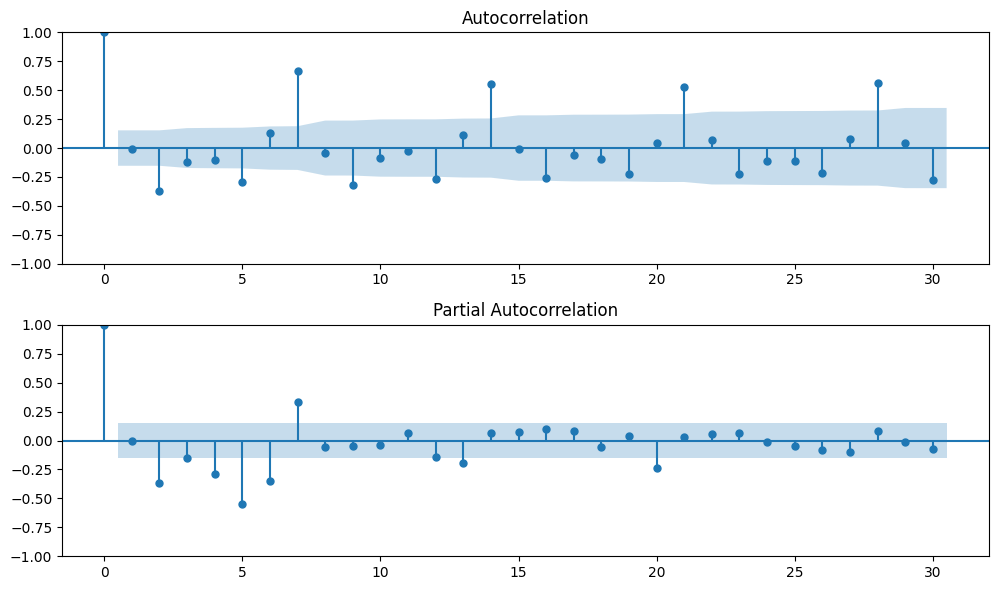

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(train_diff, ax=ax[0], lags=30)
plot_pacf(train_diff, ax=ax[1], lags=30)
plt.tight_layout()
plt.show()

> Con estos gráficos se seleccionan visualmente los valores `p` y `q`.

---

### Paso 5: Ajustar el modelo ARIMA

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Definir y entrenar el modelo (por ejemplo ARIMA(p,d,q))
model = ARIMA(train["Energia Consumida"], order=(7, 1, 5))
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jballesteros/.virtualenvs/ibbi/

                               SARIMAX Results                                
Dep. Variable:      Energia Consumida   No. Observations:                  165
Model:                 ARIMA(7, 1, 5)   Log Likelihood                -730.109
Date:                Fri, 04 Apr 2025   AIC                           1486.218
Time:                        09:43:15   BIC                           1526.516
Sample:                    07-01-2024   HQIC                          1502.577
                         - 12-12-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0705      1.567     -0.045      0.964      -3.142       3.001
ar.L2         -0.2193      1.433     -0.153      0.878      -3.028       2.590
ar.L3         -0.1515      1.539     -0.098      0.9

/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


---

### Paso 6: Hacer predicciones sobre el conjunto de validación

/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


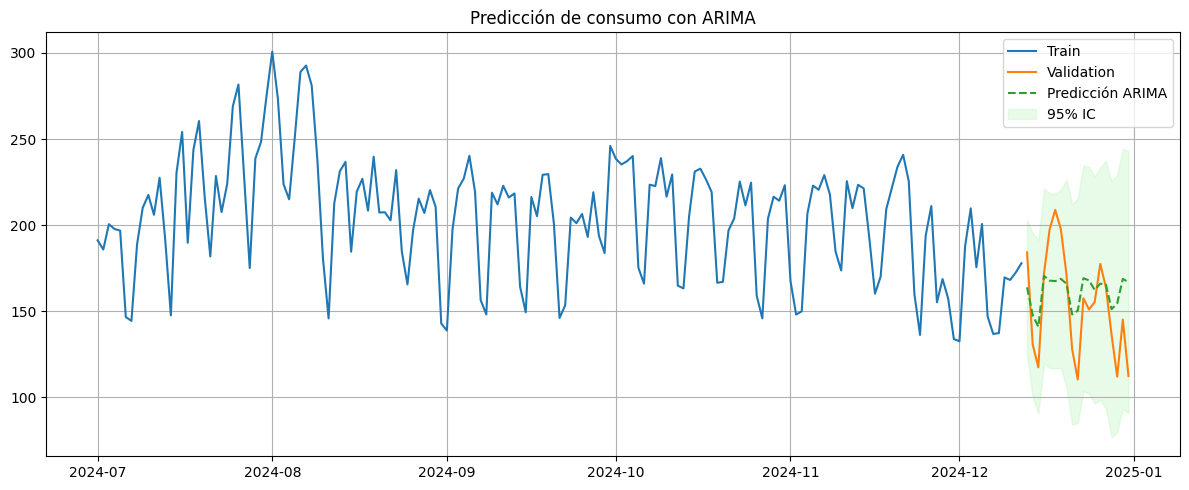

In [10]:
# Predecir sobre el rango de fechas de validación
start = val.index[0]
end = val.index[-1]
pred = model_fit.predict(start=start, end=end, typ="levels")

# Intervalo de confianza
forecast = model_fit.get_forecast(steps=len(val))
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int() 
# Visualización
plt.figure(figsize=(12, 5))
plt.plot(train.index, train["Energia Consumida"], label="Train")
plt.plot(val.index, val["Energia Consumida"], label="Validation")
plt.plot(pred.index, pred, label="Predicción ARIMA", linestyle="--")
plt.fill_between(val.index,
                 conf_int.iloc[:, 0],  # límite inferior
                 conf_int.iloc[:, 1],  # límite superior
                 color='lightgreen', alpha=0.2, label="95% IC")
plt.title("Predicción de consumo con ARIMA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 7: Evaluar el rendimiento del modelo

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val["Energia Consumida"], pred)
rmse = np.sqrt(mean_squared_error(val["Energia Consumida"], pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 21.68
RMSE: 26.05


### ¿Qué indican el MAE y el RMSE?

#### **MAE – Mean Absolute Error (Error Absoluto Medio)**

- **Qué mide:**  
  El promedio de los errores absolutos entre los valores reales y los predichos.

- **Fórmula:**  
  \[
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
  \]

- **Interpretación:**  
  Nos dice, en promedio, cuánto se desvían nuestras predicciones de los valores reales.  
  Por ejemplo, un MAE de 4 significa que, en promedio, nos estamos equivocando en ±4 unidades (p. ej., kWh, litros, etc.).

- **Ventaja:**  
  Fácil de interpretar, no amplifica los errores grandes.

---

#### **RMSE – Root Mean Squared Error (Raíz del Error Cuadrático Medio)**

- **Qué mide:**  
  El promedio del cuadrado de los errores, pero toma la **raíz cuadrada** para mantener las unidades originales.

- **Fórmula:**  
  \[
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
  \]

- **Interpretación:**  
  Similar al MAE, pero **penaliza más los errores grandes**. Es más sensible a valores atípicos (outliers).

---

## ✅ Resultado esperado

- Verificar la estacionariedad de una serie temporal.
- Aplicar diferenciación y análisis ACF/PACF para determinar parámetros.
- Ajustar un modelo ARIMA con `statsmodels`.
- Evaluar su rendimiento y analizar visualmente los resultados.
